## Libraries

In [1]:
import sys
sys.path.append('../utils')

from preprocessing import ImageProcessor, DatasetProcessor
from preprocessing import Analytics

import matplotlib.pyplot as plt
import numpy as np
import random
import os
from PIL import Image

try:
    from sklearn.cross_validation import train_test_split
except ImportError:
    from sklearn.model_selection import train_test_split  


import tensorflow as tf
import tensorflow.contrib.layers as layers

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Split dataset

In [2]:
#DatasetProcessor.file_train_test_split()

## Const params

In [3]:
image_size = 128
SEED = 42
TRAIN_PATH = '../input/train/'
VALIDATE_PATH = '../input/validate/'

random.seed(SEED)
tf.set_random_seed(SEED)

## Load the data

In [4]:
wnids_train = DatasetProcessor.get_dataset_wnids(dataset_dir=TRAIN_PATH)
wnids_test = DatasetProcessor.get_dataset_wnids(dataset_dir=VALIDATE_PATH)

wnid_to_lable = DatasetProcessor.get_wnid_table()

train = DatasetProcessor.get_dataset_paths_from_wnid(wnids_train, dataset_path=TRAIN_PATH)
test = DatasetProcessor.get_dataset_paths_from_wnid(wnids_test, dataset_path=VALIDATE_PATH)

wnid_to_one_hot = DatasetProcessor.create_wnid_to_one_hot(wnids_train)

## Exploritory analysis

In [5]:
print 'Train size:', len(train)
print 'Test size:', len(test)
print 'Class number:', len(wnids_train)

Train size: 14929
Test size: 0
Class number: 15


In [6]:
lables = [wnid_to_lable[wnid] for wnid in wnids_train]
print 'Lables:', lables

Lables: ['vedalia, Rodolia cardinalis', 'red fox, Vulpes fulva', 'trumpeter, trumpeter swan, Cygnus buccinator', 'Asiatic black bear, black bear, Ursus thibetanus, Selenarctos thibetanus', 'Hippodamia convergens', 'whitetip shark, reef whitetip shark, Triaenodon obseus', 'red wolf, maned wolf, Canis rufus, Canis niger', 'black swan, Cygnus atratus', 'tundra swan, Cygnus columbianus', 'wandering albatross, Diomedea exulans', 'black-footed albatross, gooney, gooney bird, goonie, goony, Diomedea nigripes', 'shovelhead, bonnethead, bonnet shark, Sphyrna tiburo', 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus', 'Mexican bean beetle, bean beetle, Epilachna varivestis', 'two-spotted ladybug, Adalia bipunctata']


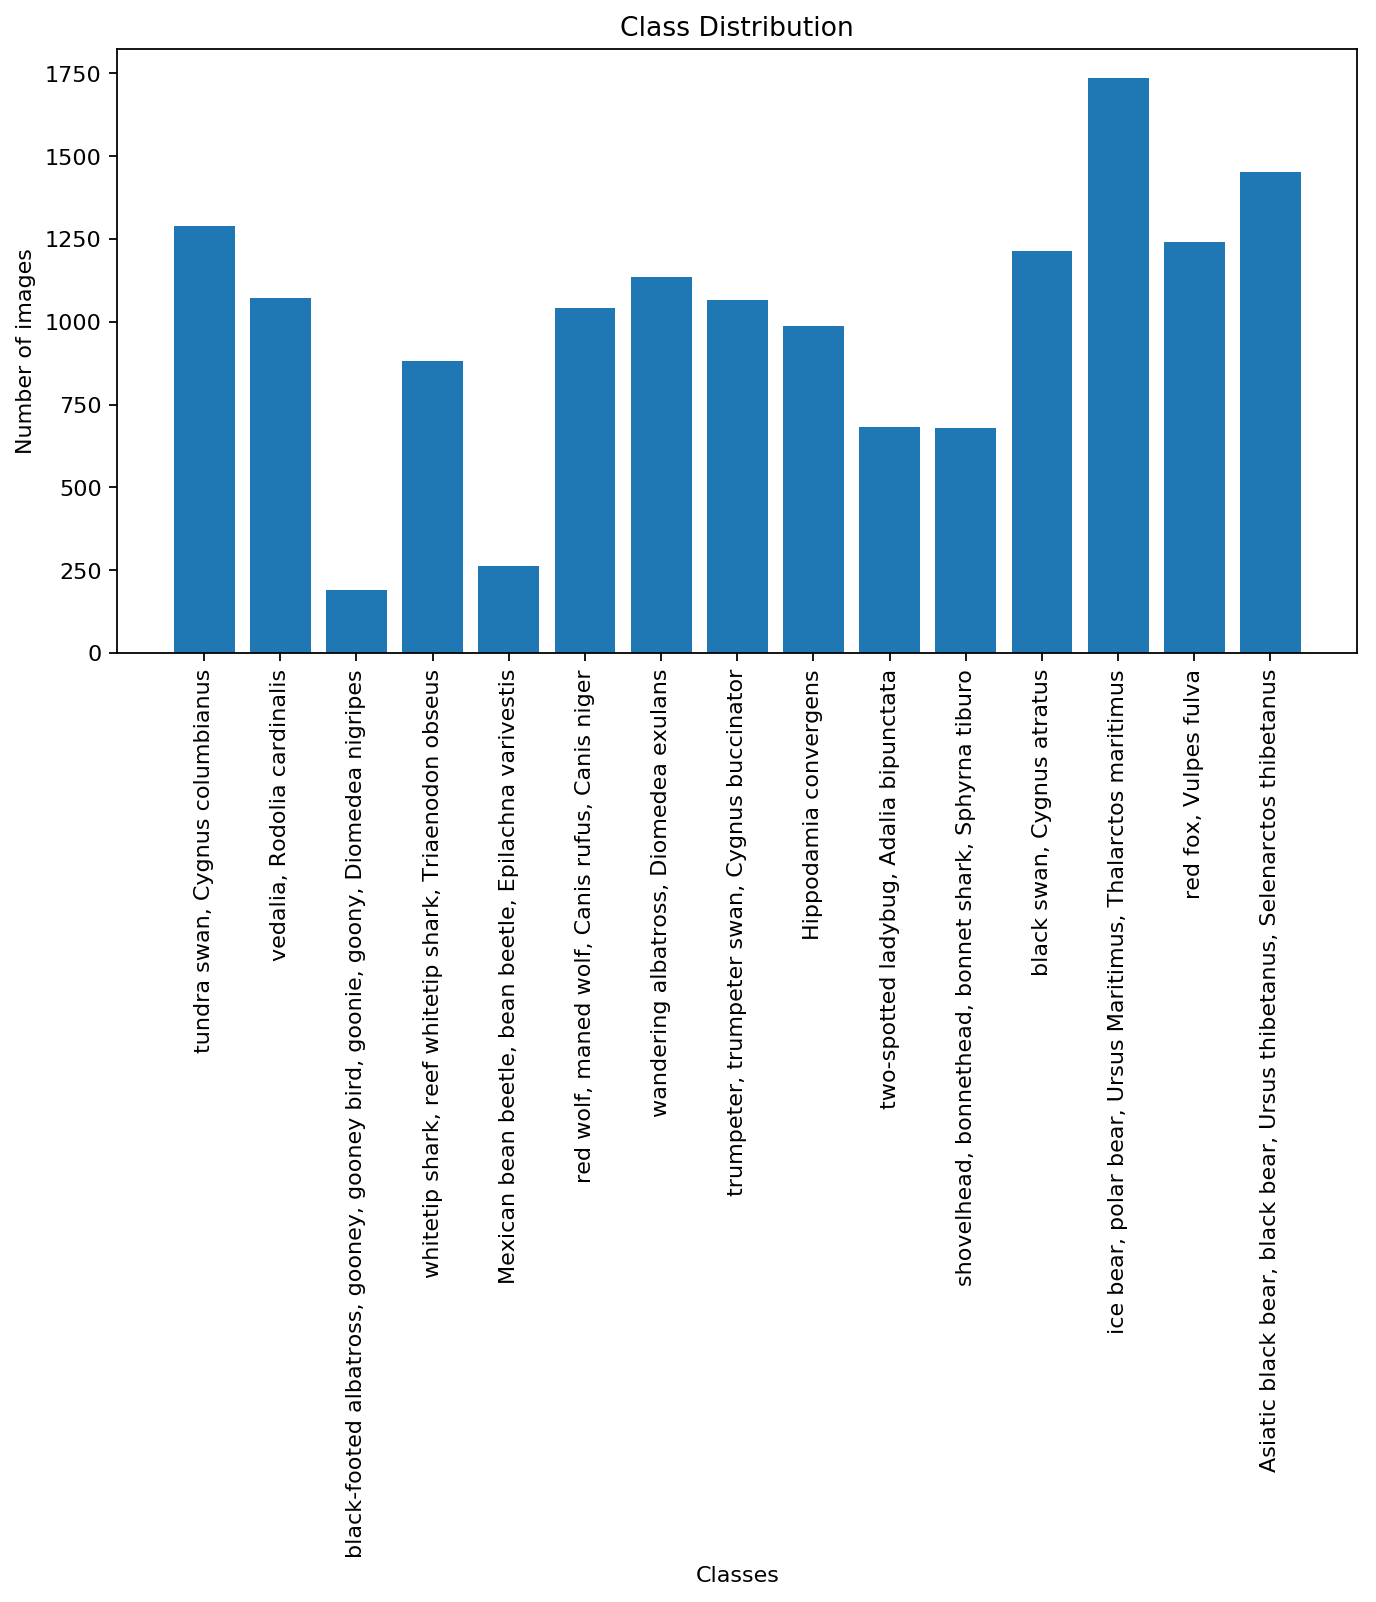

In [7]:
ImageProcessor.set_image_size(10, 5)
class_distribution = Analytics.extract_class_distribution(train)
classes = map(lambda x: wnid_to_lable[x], class_distribution.keys())

plt.bar(range(len(class_distribution)), class_distribution.values(), align='center')
plt.xticks(range(len(class_distribution)), classes, rotation='vertical')
plt.title('Class Distribution')
plt.ylabel('Number of images')
plt.xlabel('Classes')
plt.show()

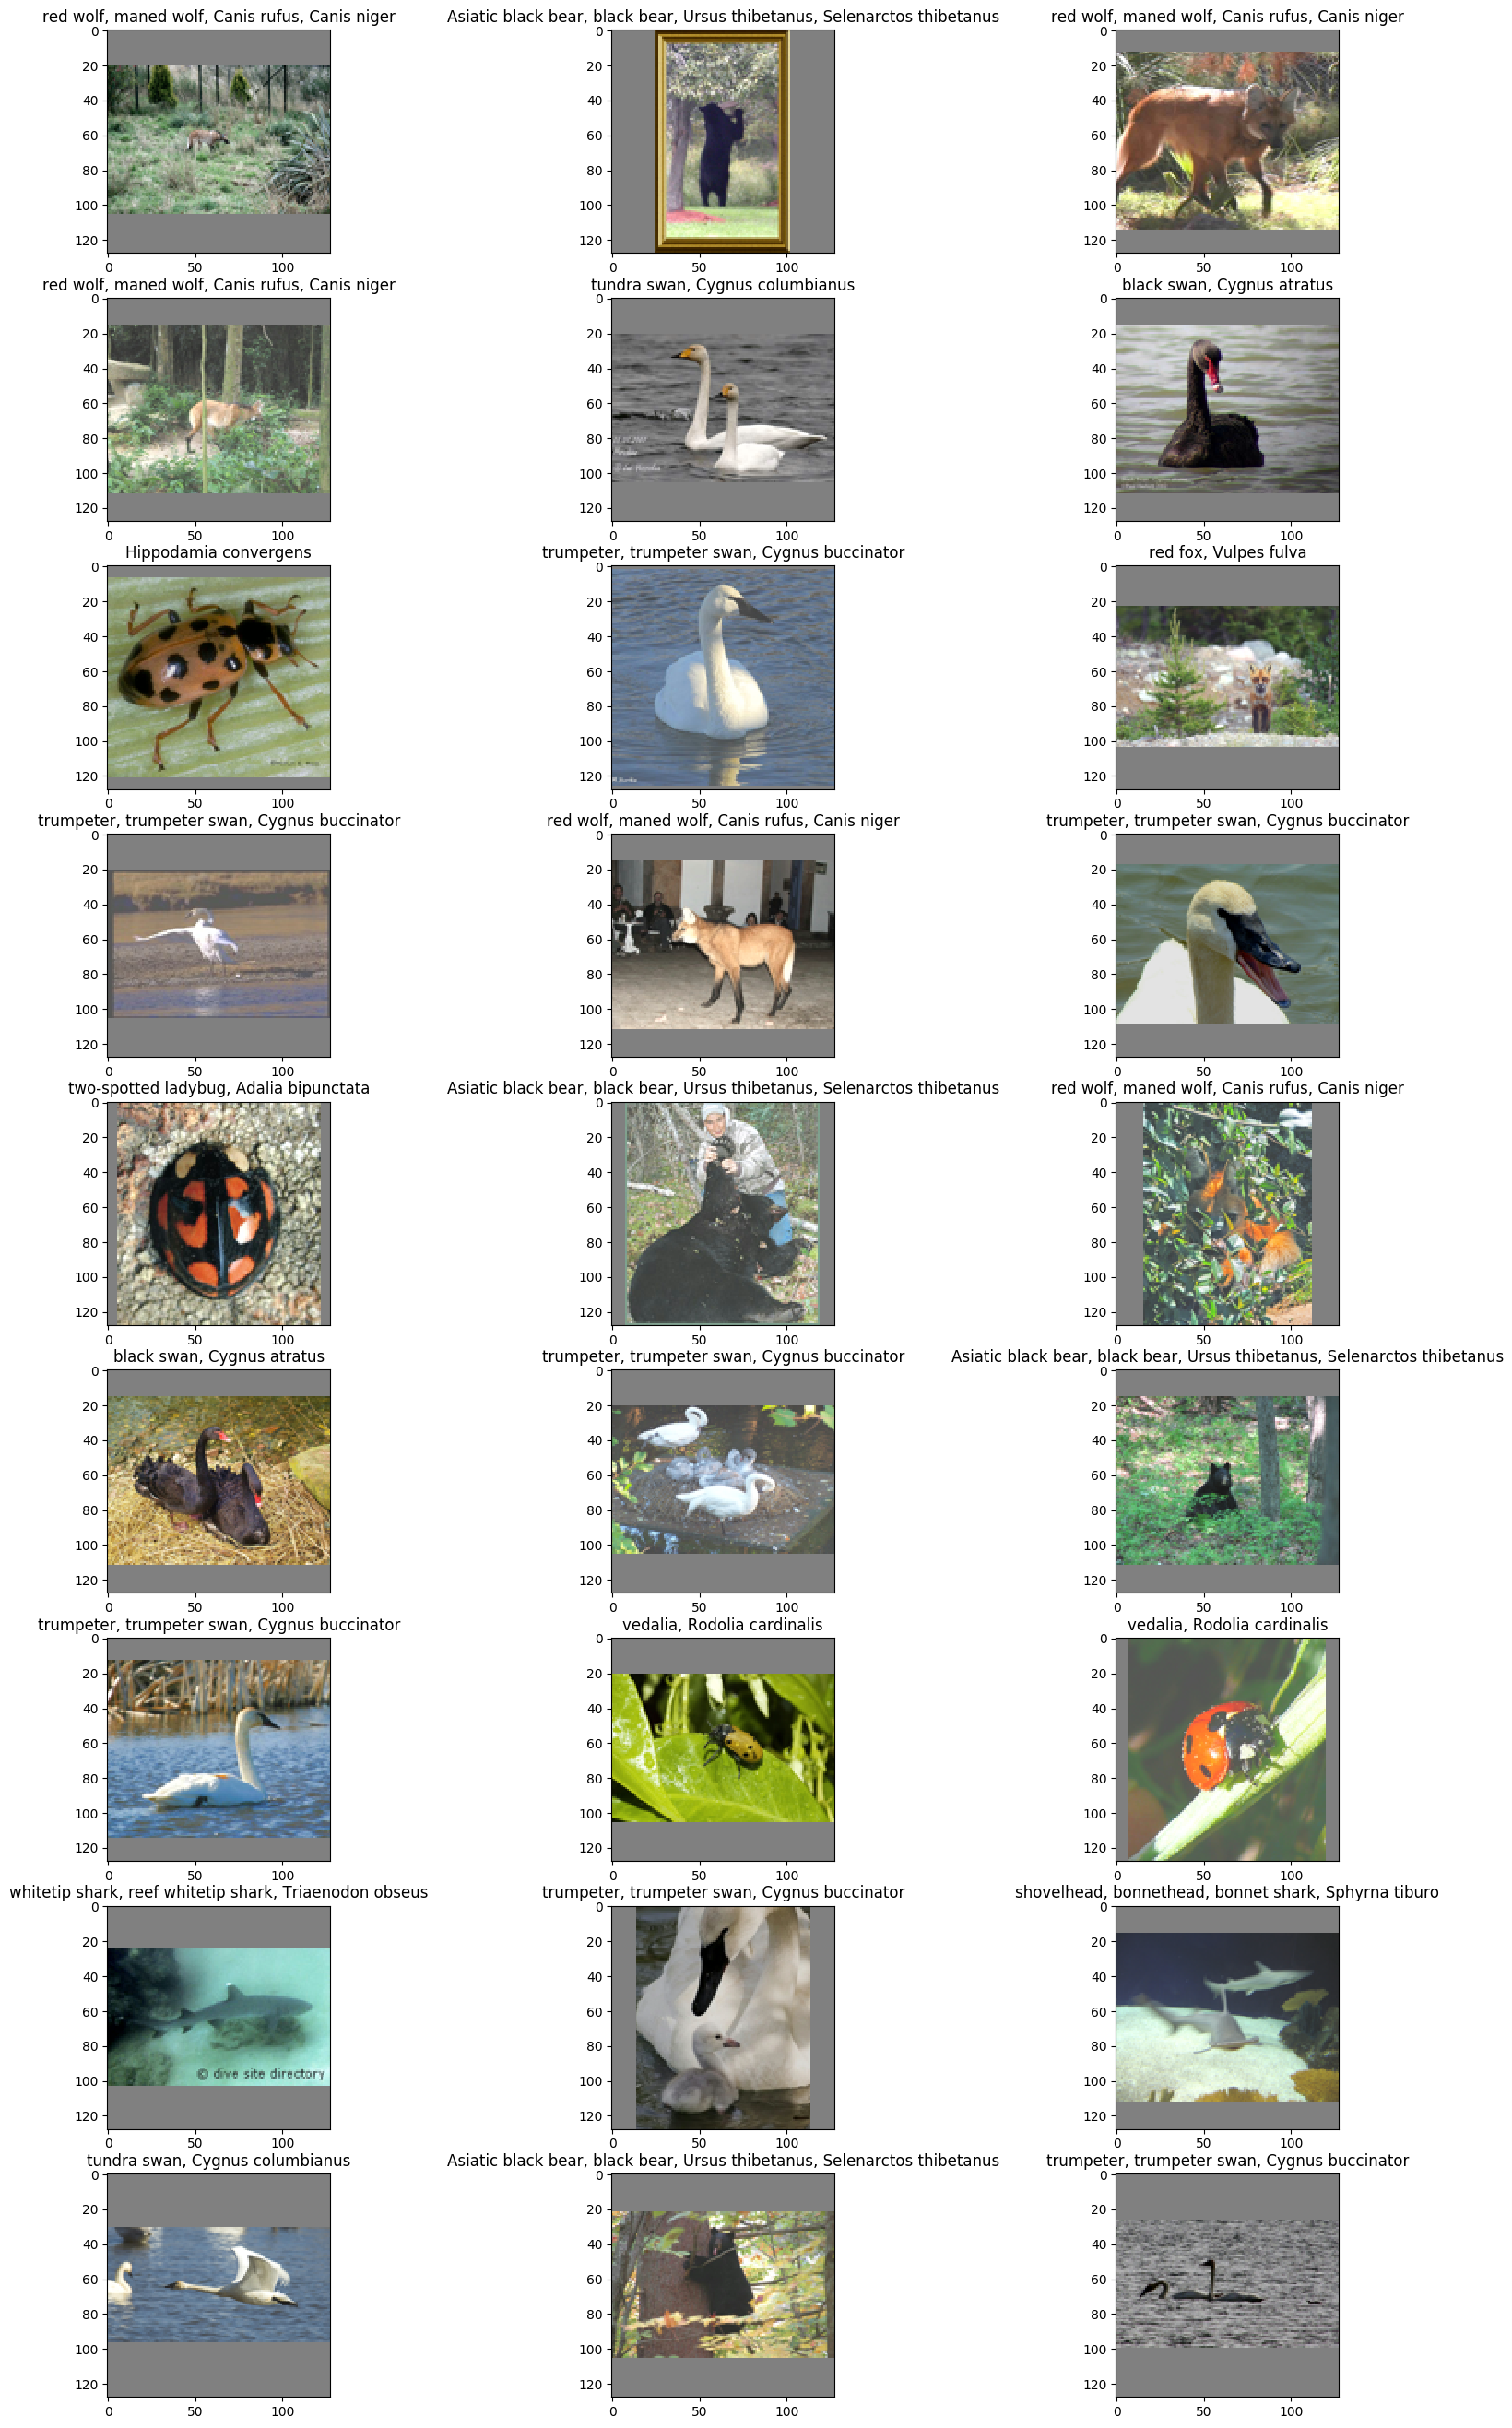

In [8]:
ImageProcessor.set_image_size(20, 34, 100)

for i in range(1, 28):
    plt.subplot(9, 3, i)
    
    random_index = np.random.randint(0, len(train))
    image_path = train[random_index]
    image = ImageProcessor.get_image(image_path)

    processed_image = ImageProcessor.get_processed_image(image, size=image_size)
    
    wnid = DatasetProcessor.extract_wnid(image_path)
    plt.title(wnid_to_lable[wnid])
    
    plt.imshow(processed_image)
    
    
plt.show()

## Data jittering

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [10]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

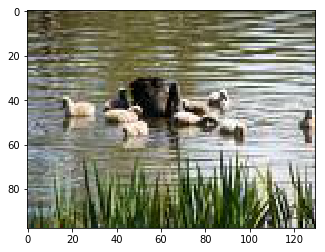

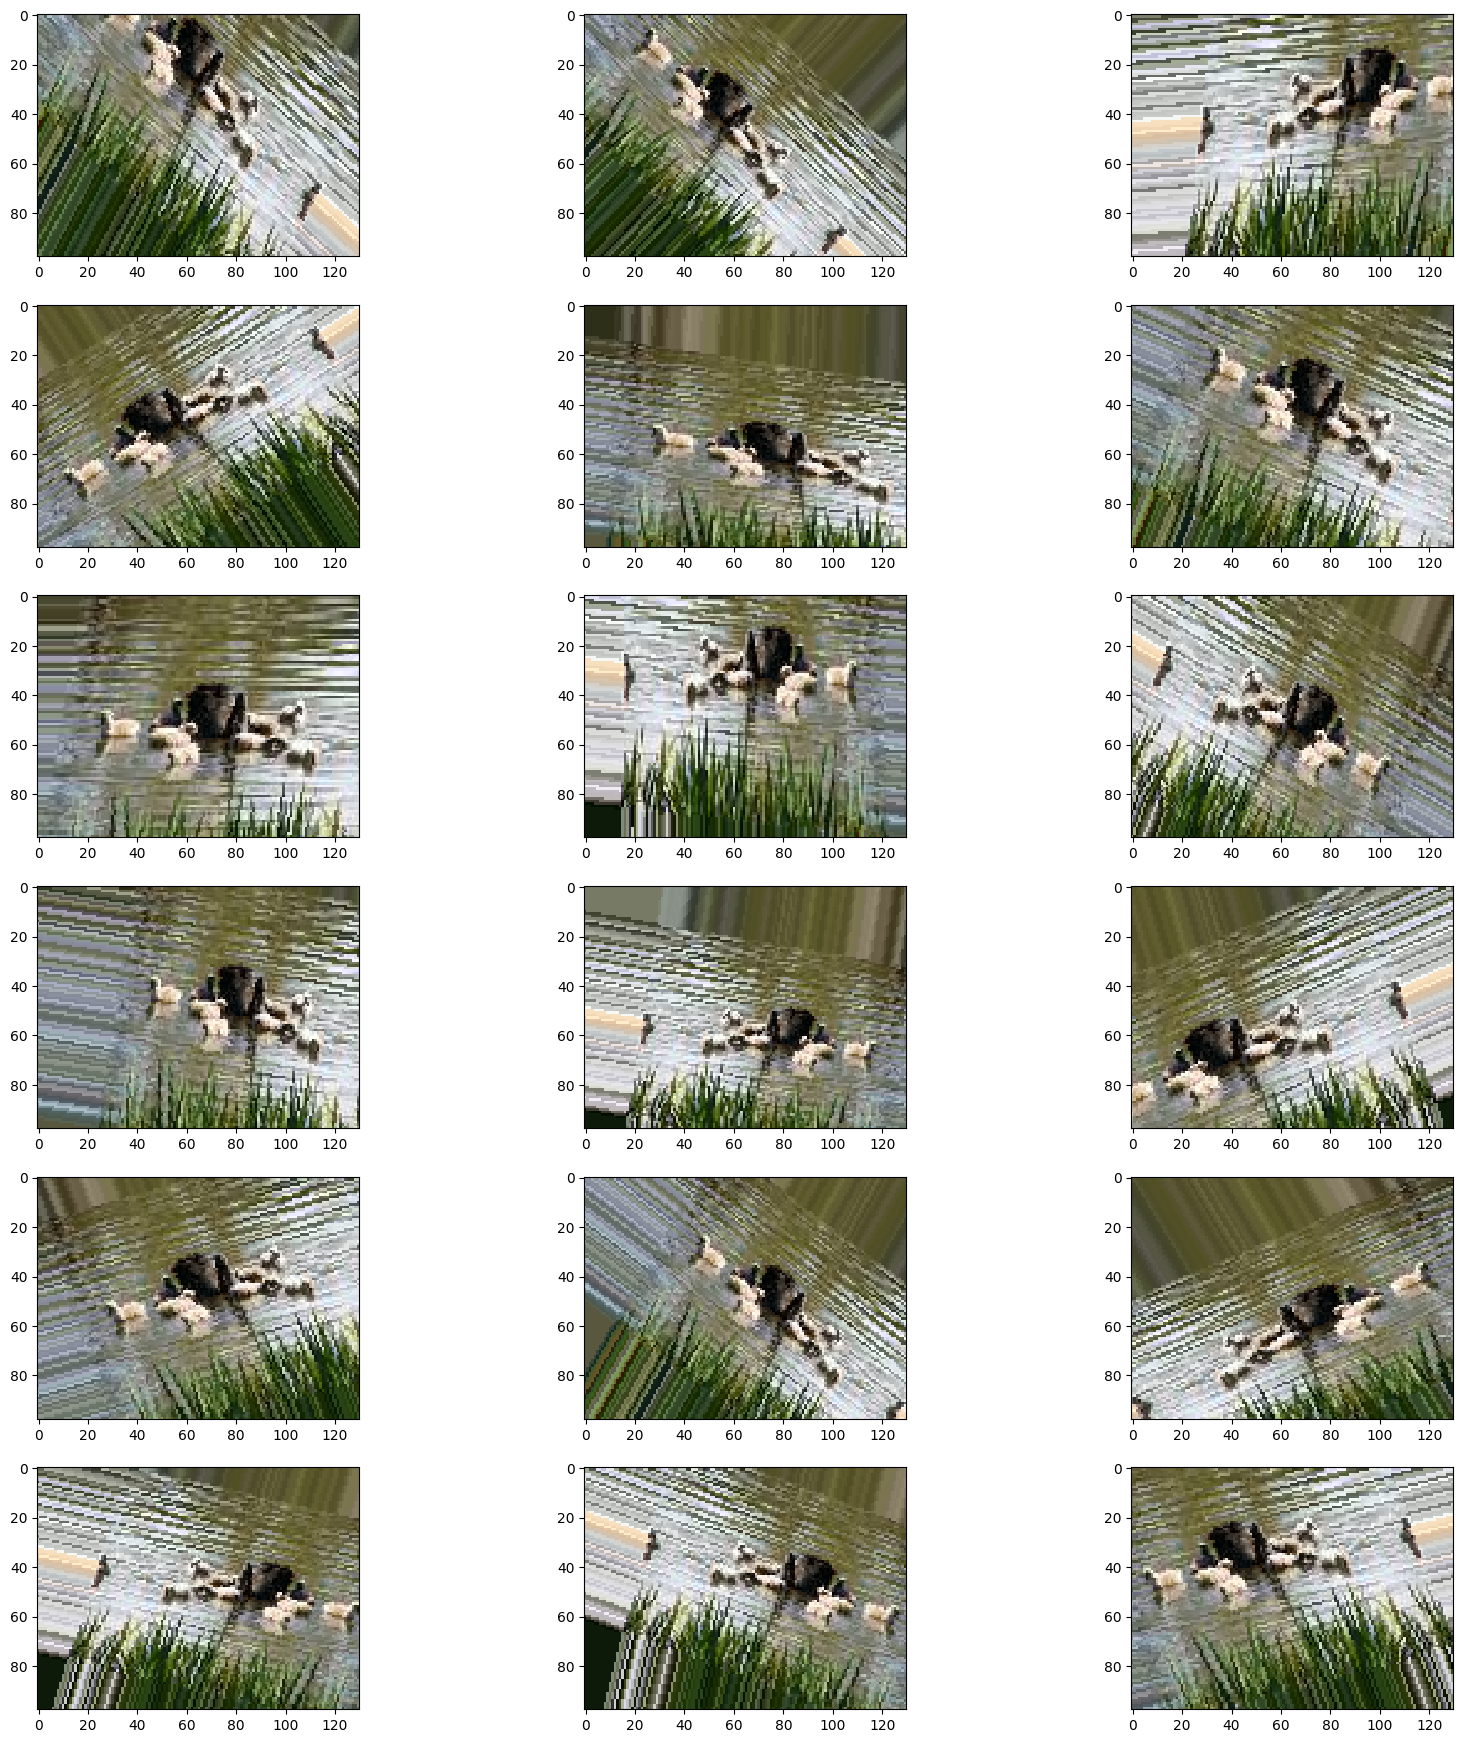

In [11]:
random_index = np.random.randint(0, len(train))
image_path = train[random_index]

img = load_img(image_path)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory

plt.imshow(img)
plt.show()

i = 0
ImageProcessor.set_image_size(20, 34, 100)
for batch in datagen.flow(x, batch_size=1):
    i += 1

    plt.subplot(9, 3, i)
    plt.imshow(batch[0,:,:,:])
        
    if i > 17:
        break  # otherwise the generator would loop indefinitely

## Baseline convnet

In [12]:
#import fileupload
#fileupload.nbinstall()

# Run in keras docker
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras_tqdm import TQDMNotebookCallback

from keras import backend as K
K.set_image_dim_ordering('tf')

In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

In [26]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [27]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 14929 images belonging to 15 classes.
Found 1649 images belonging to 15 classes.


In [28]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('shallow_model.h5')  # always save your weights after training or during training

## Deeper model

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 14929 images belonging to 15 classes.
Found 1649 images belonging to 15 classes.


In [23]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('deeper_model.h5')  # always save your weights after training or during training

## Deeper model + batch norm + agressive jittering

In [14]:
from keras.layers import Convolution2D, BatchNormalization

21/|/[loss: 1.273, acc: 0.557]   2%|| 21/933 [00:19<01:13, 12.35it/s]

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 14929 images belonging to 15 classes.
Found 1649 images belonging to 15 classes.


In [20]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('batch_norm.h5')  # always save your weights after training or during training

## Pretrained convnet

In [6]:
from keras import applications

In [7]:
model = applications.VGG16(include_top=False, weights='imagenet')

In [23]:
batch_size = 16

generator = datagen.flow_from_directory(
        '../input/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)

# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(generator, 14929)
# save the output as a Numpy array
np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)

generator = datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
bottleneck_features_validation = model.predict_generator(generator, 1649)
np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

Found 14929 images belonging to 15 classes.
Found 1649 images belonging to 15 classes.


In [ ]:
train_data = np.load(open('bottleneck_features_train.npy'))
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * 1000 + [1] * 1000)

validation_data = np.load(open('bottleneck_features_validation.npy'))
validation_labels = np.array([0] * 400 + [1] * 400)

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model.h5')